In [1]:
# imports
from kmsr import KMSR
from sklearn.datasets import make_blobs
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import DistanceMetric
from scipy.spatial.distance import euclidean
import random
import itertools

# FPT Approximations for Fair k-Min-Sum-Radii

#### Creating example data

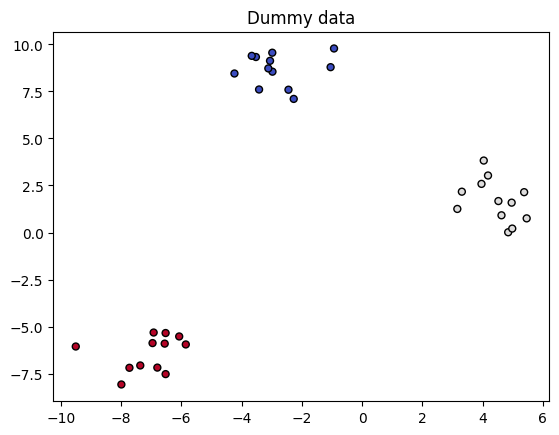

In [2]:
# generate dummy data
k = 3
points, cluster_membership = make_blobs(
    n_samples=36,
    n_features=2,
    centers=k,
    random_state=42
)

plt.title("Dummy data")
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=25, edgecolor="k", cmap="coolwarm")
plt.show()


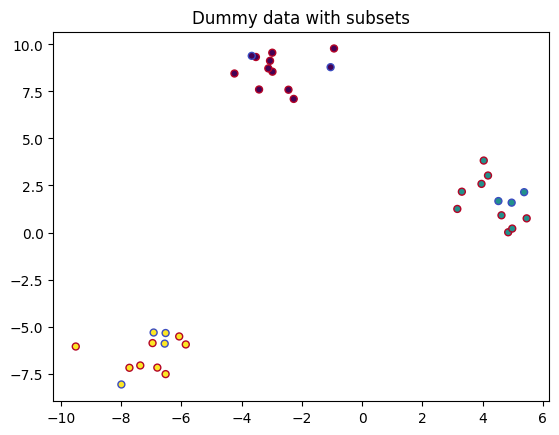

In [3]:
# choosing points to represent two subsets in 1:3 ratio:
subset_membership = np.array([10 if index % 4 == 0 else 200 for index in range(len(points))])


cmap=plt.cm.coolwarm
norm = mcolors.Normalize(vmin=min(subset_membership), vmax=max(subset_membership))
edge_colors = cmap(norm(subset_membership))
plt.title("Dummy data with subsets")
plt.scatter(points[:, 0], points[:, 1], marker='o',c=cluster_membership, s=25, edgecolor=edge_colors)
plt.show()

# The Algorithm

## 1. Constructing unfair clusters that contain the optimal solution
Necessary subroutines: guessing centers -> k-completion -> Gonzalez, guessing radii 

In [4]:
# distance function
"""def dist(p1, p2):
    return sum((a - b) ** 2 for a, b in zip(p1, p2)) ** 0.5"""
dist = DistanceMetric.get_metric('euclidean')

To better understand the following k_completion implementation, it is helpful to first remember the basics of farthest-first traversal implemented in Gonzalez. This algorithm already achieves a 2-approximation for unfair clustering, which leads to remarkably accurate centers, even if you start with a randomly selected one.

In [5]:
def gonzalez(points, k):
    points = np.array(points)
    n = len(points)
    centers = []

    start_idx = np.random.choice(n)
    centers.append(points[start_idx])
    
    if(k==1):
        return centers

    while(len(centers) < k):
        dists = np.min(dist.pairwise(points, np.array(centers)), axis=1) # the axis attribute stops it from returning the same center over and over again
        
        farthest_idx = np.argmax(dists)
        centers.append(points[farthest_idx])

    return np.array(centers)
print("Example:")
print(gonzalez(points, 5))

Example:
[[ 4.96396281  1.5880874 ]
 [-9.4993723  -6.05820709]
 [-3.6601912   9.38998415]
 [-5.84862767 -5.94882947]
 [-0.92998481  9.78172086]]


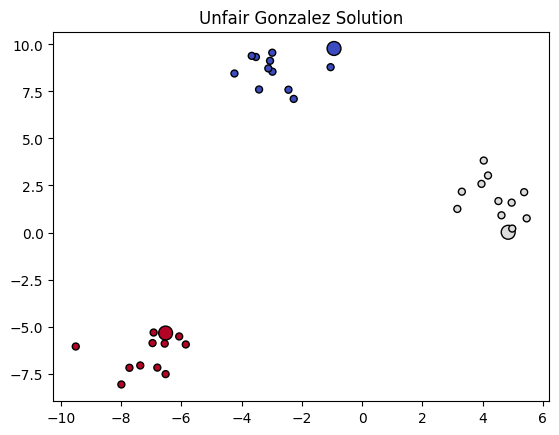

In [6]:
# centers are enlarged
gonzalez_solution = gonzalez(points, k)
plt.title("Unfair Gonzalez Solution")
sizes = [100 if tuple(point) in map(tuple, gonzalez_solution) else 25 for point in points]
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=sizes, edgecolor="k", cmap="coolwarm")
plt.show()

In [7]:
def k_completion(points, centers, k):

    if(k==len(centers)):
        return centers
    
    if(len(centers)==0):
        centers.append(points[np.random.choice(len(points))])

    while(len(centers) < k):
        dists = np.min(dist.pairwise(points, np.array(centers)), axis=1) # the axis attribute stops it from returning the same center over and over again
        
        farthest_idx = np.argmax(dists)
        centers.append(points[farthest_idx])

    return centers

#### Modified distance function
However, this approach might fail for overlapping clusters as described in the paper (figure 2). Due to this, we first want to guess a radius profile that we can then fit to guessed centers, using a modified distance function.

In [8]:
def dist_m(point_a, point_b, centers, radii):
    if point_a and point_b in centers:
        return max(dist(point_a, point_b) - radii[centers.index(point_a)] - radii[centers.index(point_b)], 0)
    elif point_a in centers:
        return max(dist(point_a, point_b) - radii[centers.index(point_a)], 0)
    elif point_b in centers:
        return max(dist(point_a, point_b) - radii[centers.index(point_b)], 0)
    else:
        return dist(point_a, point_b)

#### Guessing radii
For ease of implementation, we assume epsilon to be 0.5.\\
We also need an Approximation for a k-msr solution, for which we will use a heursitic approach developed in https://github.com/algo-hhu/k-min-sum-radii

#### Approximation of kmsr
For an upper bound of possible radii, we approximate a kmsr solution

In [9]:
# estimation of kmsr
def kmsr_heuristic(points, k, random_state):
    kmsr = KMSR(n_clusters=k,
                algorithm="FPT-heuristic",
                epsilon=0.5,
                n_u=10000,
                n_test_radii=10,
                random_state=random_state)
    kmsr.fit(points)
    return kmsr.cluster_radii_

In [10]:
def guessing_radii(points, k):
    radii = []
    # first we need to guess the largest radius, to decrease our guessing interval from there
    # for that we need an estimated kmsr solution as upper bound

    kmsr = kmsr_heuristic(points, k, random.randint(0,k^k)) 
    
    # because we used a 1+epsilon approximation, we can simlify the equation a lot
    epsilon = 0.5
    for radius in kmsr:
        radii.append((1+epsilon)*radius)
    while(len(radii) < k): 
        radii.append(0.0) # we need exactly k radii for our purposes, this heuristic provides approximations with up to k radii so we add the rest as 0.0
    return radii


solution = guessing_radii(points, k=5)
print(solution)  

c:\Users\Mattis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\Mattis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[np.float64(0.0), np.float64(2.3176419254656087), np.float64(2.7662138725302934), np.float64(2.4804039841950027), np.float64(0.0)]


#### First step algorithm
Described as Algorithm 2 in the paper

In [11]:
def algorithm_2(points, k, radii, assignment_tuple):
    guessed_centers = k_completion(points=points, centers = [], k=k)
    for i in range(k):
        temp_centers = k_completion(points=points, centers = guessed_centers[:i], k=k)
        if(assignment_tuple[i]<i):
            radii[assignment_tuple[i]] += 3 * radii[i]
            radii[i] == 0
            temp_centers[i] == random.choice(points)
        elif(assignment_tuple[i] >= i):
            temp_centers[i] = temp_centers[assignment_tuple[i]]
            radii[i] = 3 * radii[i]
        guessed_centers = k_completion(points=points, centers=temp_centers[:i+1], k=k)
    return guessed_centers, radii

# print(algorithm_2(points, k=5, radii=guessing_radii(points, k=5), assignment_tuple=[4, 3, 2, 1, 0]))

In [12]:
def get_assignment_tuples(k):
    nums = list(range(k))
    permutations = list(itertools.permutations(nums))
    permutations = [list(p) for p in permutations]
    return permutations

## 2. Fair Assignment
Now that we have a preliminary clustering, we need to fit it to a fair assignment. Simply splitting the clusters into fairlets does not work according to the paper. Instead, an access graph is created to approximate fair mergers of clusters which produce a result that is not _too_ out of scale compared to the optimal solution. This is achieved by building connected components from point-to-center assignment. So if a point is covered by multiple radii, meaning it could belong to multiple centers, the components for both clusters get merged. This leads to larger than ideal, but definitely fair clustering.

In [ ]:
def assign_point(point, center, assignment):
    assignment.append((point, center))
    return assignment

def assign_points(points, centers, radii, assignment=[]):
    for point in points:
        for i in range(len(centers)):
            if(euclidean(point, centers[i]) <= radii[i]):
                assignment = assign_point(point, centers[i], assignment)
    return assignment


# these components still need to be merged
def build_components(centers, assignment):
    components = []
    for center in centers:
        components.append([])
    for i in range(len(components)):
        for tuple in assignment:
            if (tuple[1] == centers[i]).all() and not any(np.array_equal(tuple[0], node) for node in components[i]):
                components[i].append(tuple[0])
    return components

def build_graph_from_components(components):
    graph = []
    for component in components:
        graph.append(component)
    return graph

'# we could use dfs to find connected components\ndef dfs(graph, node, visited, component):\n    visited.add(node)\n    component.append(node)\n    for neighbor in graph[node]:\n        if neighbor not in visited:\n            dfs(graph, neighbor, visited, component)\n\n    visited = set()\n    merged = []\n    for node in graph:\n        if node not in visited:\n            component = []\n            dfs(graph, node, visited, component)\n            merged.append(sorted(component))\n\n    result = []\n    seen = set()\n    for group in merged:\n        frozen = frozenset(group)\n        if frozen not in seen:\n            seen.add(frozen)\n            result.append(group)\n\n    return result'

#### Second step algorithm
Finding the center in each component that minimizes the radius needed to cover the entire component:

In [14]:
# Algorithm 3 in the paper
def fair_assignment(graph, centers, dist=dist):
    final_centers = []
    final_assignment = []
    for component in graph:
        candidates = []
        for node in component:
            if any(np.array_equal(node, center) for center in centers):
                candidates.append(node)
        radii = []
        for candidate_center in candidates:
            distances = []
            for node in component:
                distances.append(euclidean(node, candidate_center))
            radii.append(max(distances))
        # choosing the largest possible radius ensures that all combined radii of the previus solution are contained within, while at the same time not enlarging the cluster by more than a factor of 2
        final_center = candidates[radii.index(max(radii))]
        final_centers.append(final_center)
        for node in component:
            final_assignment.append((node, final_center))
    return final_centers, final_assignment 

## Putting it all together

In [15]:
# ugly chatgpt solution because somehow this is where my brain stopped

def msr(centers, elements):
    # Group points by their center
    center_to_points = defaultdict(list)
    for point, center in elements:
        center_to_points[tuple(center)].append(point)  # tuple makes center hashable

    # Calculate the maximum distance (radius) for each center
    total = 0
    for center in centers:
        center_key = tuple(center)
        points = center_to_points.get(center_key, [])
        if points:
            radius = max(euclidean(center, p) for p in points)
        else:
            radius = 0  # No points assigned
        total += radius

    return total

In [16]:
def algorithm_4(points, k, dist=dist):
    final_centers = [] 
    final_assignment = []
    upper_bound = (6+0.5)*max([euclidean(a, b) for a in points for b in points])
    radius_profile_guesses = [guessing_radii(points, k) for i in range(k)]
    assignment_tuples = get_assignment_tuples(k)
    for profile in radius_profile_guesses:
        for tuple in assignment_tuples:
                center_candidates, radius_profile = algorithm_2(points, k, profile, tuple)
                assignment = assign_points(points, center_candidates, radius_profile)
                graph_components = build_components(center_candidates, assignment)
                graph = build_graph_from_components(graph_components)
                guessed_centers, guessed_assignment = fair_assignment(graph, center_candidates)
                guessed_solution = msr(guessed_centers, guessed_assignment)
                if guessed_solution < upper_bound:
                    final_centers, final_assignment = guessed_centers, guessed_assignment
                    upper_bound = guessed_solution
    return final_centers, final_assignment, upper_bound

In [17]:
final_centers, final_assignment, upper_bound = algorithm_4(points, k)
print("centers:", final_centers)
print("approximation:", upper_bound)

c:\Users\Mattis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\Mattis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Mattis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\Mattis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:474: FutureWarning: `Base

centers: [array([-6.51799117, -7.52522935]), array([-0.92998481,  9.78172086]), array([4.84874243, 0.01349956])]
approximation: 15.933705459875666
